## Churn Modeling

In [150]:
rm(list=ls())
v <- View
set.seed(123) 
options(warn=-1)
suppressMessages(require(data.table))
suppressMessages(require(plyr))
suppressMessages(require(dplyr))
suppressMessages(require(gtools))
suppressMessages(require(caret))
suppressMessages(require(lubridate))
suppressMessages(require(ggplot2))

In [151]:
####################################################################################
############               Step 1: Read in the datasets                 ############
####################################################################################
# Read each data 
rideTimestamp <- fread('ride_timestamps.csv', header = TRUE, stringsAsFactors = FALSE, na.strings = c('NA', 'NULL', '\\N', ''), sep='auto')
rideIds <- fread('ride_ids.csv', header= TRUE, stringsAsFactors = FALSE, na.strings = c('NA','NULL','\\N', ''), sep = 'auto')
driverIds <- fread('driver_ids.csv', header = TRUE, stringsAsFactors = FALSE, na.strings = c('NA', 'NULL', '\\N', ''), sep='auto')

# Prep the three datasets
rideTimestamp <- rideTimestamp %>% mutate(ride_id = as.character(ride_id), ride_picked_up_at  = as.POSIXct(ride_picked_up_at, format = "%Y-%m-%d %H:%M:%S"),
                                          ride_date = lubridate::date(ride_picked_up_at), ride_DOY = as.integer(strftime(ride_date, format = "%j")), ride_hour = lubridate::hour(ride_picked_up_at),
                                          ride_month = lubridate::month(ride_picked_up_at), ride_weekNum = as.integer(strftime(ride_date,format="%W")),  #lubridate::isoweek(ymd(ride_date)),
                                          ride_weekDay = lubridate::wday(ride_date), ride_weekName = weekdays(ride_date))

rideIds <- rideIds %>% mutate(driver_id = as.character(driver_id), ride_id = as.character(ride_id), ride_distance = as.integer(ride_distance),
                              ride_duration = as.integer(ride_duration), ride_prime_time = as.integer(ride_prime_time))

driverIds <- driverIds %>% mutate(driver_id = as.character(driver_id), driver_onboard_date =  as.POSIXct(driver_onboard_date, format = "%Y-%m-%d %H:%M:%S"),
                                  onboard_date = lubridate::date(driver_onboard_date), onboard_month = lubridate::month(onboard_date))

In [152]:
####################################################################################
############                  Step 2: Data exploration                  ############
####################################################################################
# Lets look at the summary of each dataframe
summary(rideIds)

# Looks at the occurance of NAs in each of the df
rideTimestamp %>% summarise_all(funs(sum(is.na(.))))
rideIds %>% summarise_all(funs(sum(is.na(.))))
driverIds %>% summarise_all(funs(sum(is.na(.))))

  driver_id           ride_id          ride_distance    ride_duration  
 Length:193502      Length:193502      Min.   :    -2   Min.   :    2  
 Class :character   Class :character   1st Qu.:  2459   1st Qu.:  491  
 Mode  :character   Mode  :character   Median :  4015   Median :  727  
                                       Mean   :  6955   Mean   :  859  
                                       3rd Qu.:  7193   3rd Qu.: 1069  
                                       Max.   :724679   Max.   :28204  
 ride_prime_time 
 Min.   :  0.00  
 1st Qu.:  0.00  
 Median :  0.00  
 Mean   : 17.31  
 3rd Qu.: 25.00  
 Max.   :500.00  

ride_id,ride_picked_up_at,ride_date,ride_DOY,ride_hour,ride_month,ride_weekNum,ride_weekDay,ride_weekName
0,0,0,0,0,0,0,0,0


driver_id,ride_id,ride_distance,ride_duration,ride_prime_time
0,0,0,0,0


driver_id,driver_onboard_date,onboard_date,onboard_month
0,0,0,0


From the summary above we see that there is a ride with a ride_distance of -2 which looks erroneous. We will come back to this later.

In [153]:
# Lets make sure we have no duplicate records (for each dataset)
checkForDriverIds <- driverIds %>% group_by(driver_id) %>% summarise(occurance = n())
show(paste('Are there any duplicate records for onboard date per each driver id ? ', any((checkForDriverIds$occurance > 1))))
checkForRideIds <- rideIds %>% group_by(driver_id, ride_id) %>% summarise(occurance = n())
show(paste('Are there any duplicate records for each driver_id, ride_id  pair ? ', any(checkForRideIds$occurance > 1)))
checkForRideTimestamp <- rideTimestamp %>% group_by(ride_id) %>% summarise(occurance = n())
show(paste('Are there any duplicate records for ride_picked_up timestamp for each ride ? ', any(checkForRideTimestamp$occurance > 1)))


[1] "Are there any duplicate records for onboard date per each driver id ?  FALSE"
[1] "Are there any duplicate records for each driver_id, ride_id  pair ?  FALSE"
[1] "Are there any duplicate records for ride_picked_up timestamp for each ride ?  FALSE"


In [154]:
# Next, we only want to look at drivers who have completed atleast one ride (that is 'active drivers'). 
# Are all driver_id in the driverIds df also present in the rideIds df ? Let's take a look
checkFromRideDF <- rideIds %>% group_by(driver_id) %>% summarise(occurance = 1)
checkFromDriverDF <- merge(checkFromRideDF, checkForDriverIds, all = TRUE, by = c('driver_id'))
testForOnBoardDate <- subset(checkFromDriverDF, is.na(occurance.y))
testForRides <- subset(checkFromDriverDF, is.na(occurance.x))
show(paste("Number of drivers who haven't completed a single ride : ", nrow(testForRides)))

[1] "Number of drivers who haven't completed a single ride :  83"


There is a segment of drivers who have joined the platform but haven't completed any rides. Can we incentivize them to do so ?

In [155]:
# Let's merge these datasets to work with just one moving forward(include only active drivers)
combine <- merge(rideIds, driverIds, all.x = TRUE, by = c('driver_id'))
rides_driver_info <- merge(combine, rideTimestamp, by = c('ride_id'))

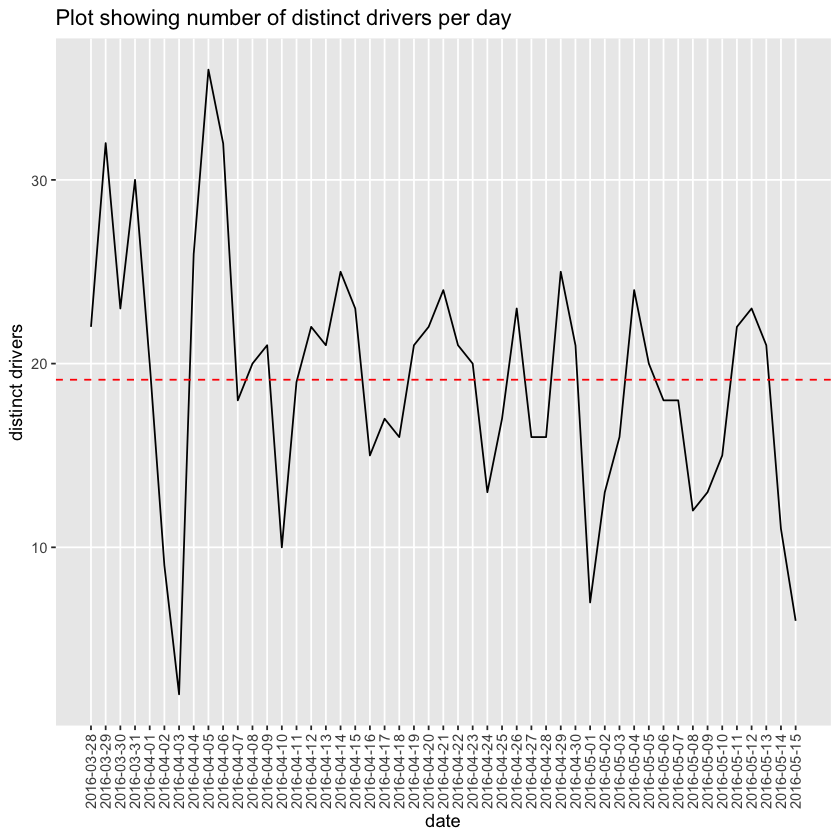

In [156]:
############   Analyze driver data    ############
# Let's aggregate and look at the total drivers per date
aggDriver <- driverIds %>% group_by(onboard_date) %>% dplyr::summarise(distinctDrivers = n_distinct(driver_id))
brks <- aggDriver$onboard_date 

# plot
ggplot(aggDriver, aes(x = onboard_date)) + geom_line(aes(y=distinctDrivers)) +
   labs(title = 'Plot showing number of distinct drivers per day', y = 'distinct drivers', x = 'date') + 
   scale_x_date(labels = brks, breaks = brks) +
   theme(axis.text.x = element_text(angle = 90, vjust = 0.5), panel.grid.minor = element_blank()) +
   geom_hline(yintercept=mean(aggDriver$distinctDrivers),  color="red", linetype="dashed")

We see that on average 19 drivers sign-up on the platform everyday with a maximum here of 36 drivers.

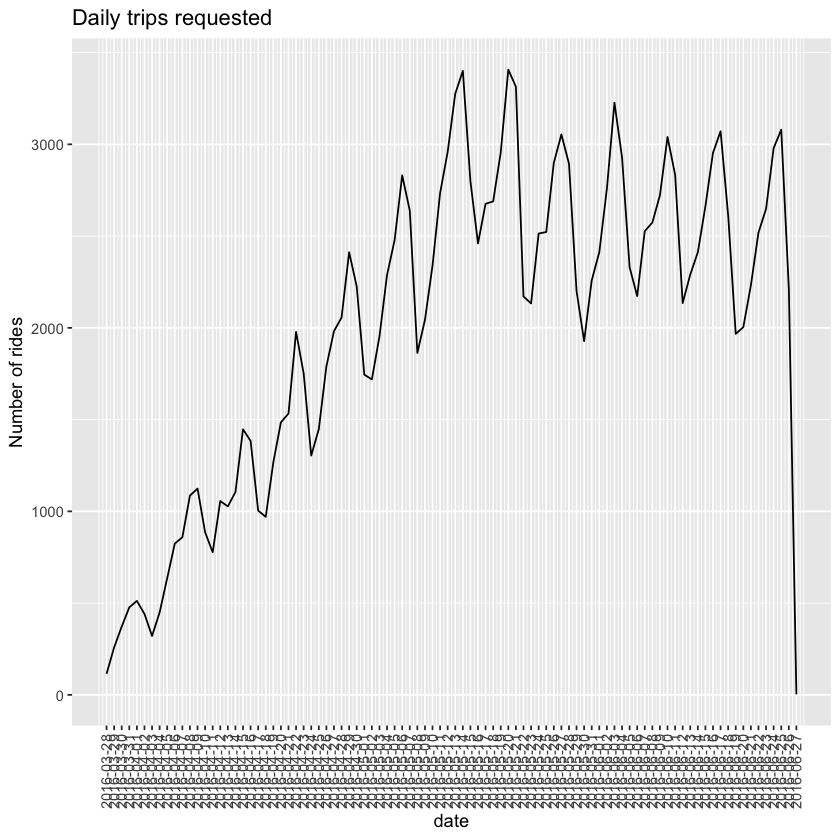

In [157]:
############   Analyze ride data   ############


# Lets take a look at the number of requested rides per day / month (from 2016-03-28 to 2016-06-27)
ridesRequestedPerDay <- rides_driver_info %>% group_by(ride_date)  %>% summarise(numOfRequestsDaily = n_distinct(ride_id))
ridesRequestedPerMonth <- rides_driver_info %>% group_by(ride_month) %>% summarise(numOfRequestsMonthly = n_distinct(ride_id))

brks <- ridesRequestedPerDay$ride_date
ggplot(ridesRequestedPerDay, aes(x = ride_date)) + geom_line(aes(y = numOfRequestsDaily)) + scale_x_date(labels = brks, breaks = brks) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5)) + labs(title = 'Daily trips requested', y = 'Number of rides', x = 'date')

We see the seasonal behavior of rides in the above graph, that is the number of rides requested steadily increases as the weekend appraoches with it peaking on Fridays. The peaks also increase because as drivers onboard number of  rides completed also increase. We can also see the linear trend until 2016-05-12 after which this trend is slightly damped.  

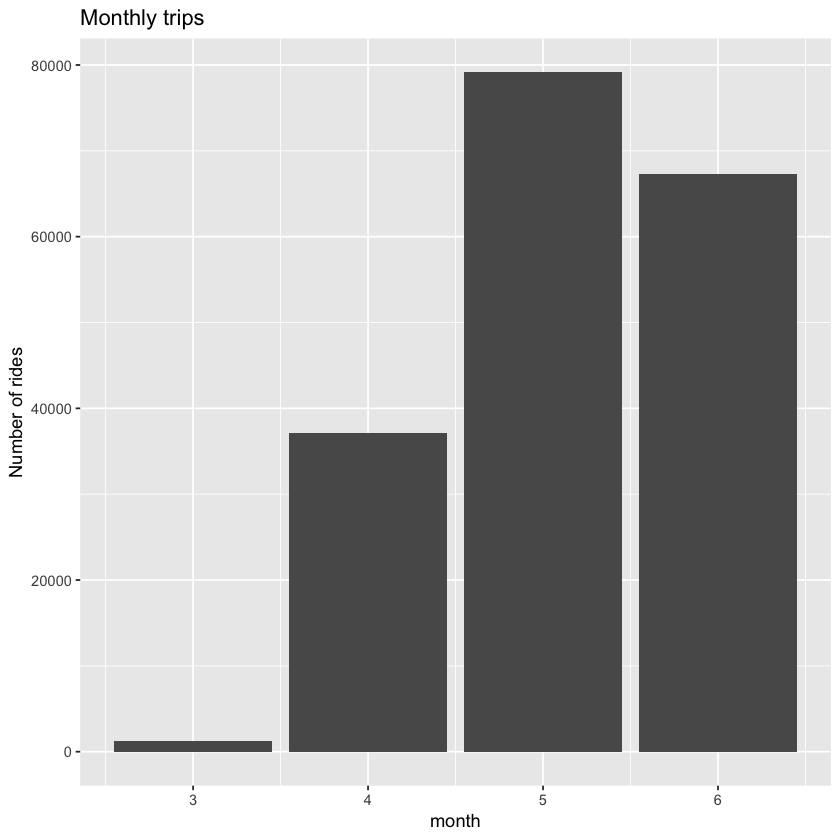

In [158]:
ggplot(ridesRequestedPerMonth, aes(x = ride_month, y = numOfRequestsMonthly)) + geom_bar(stat="identity") +  labs(title = 'Monthly trips', y = 'Number of rides', x = 'month')

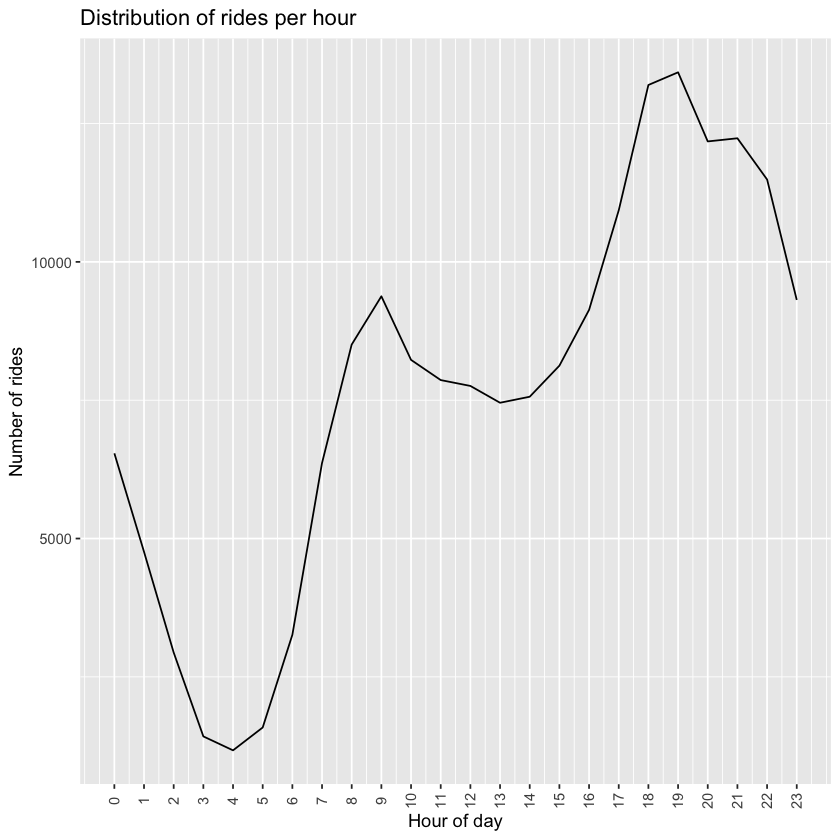

In [159]:
# Lets take a look by the hour
ridesRequestedPerHour <- rides_driver_info %>% group_by(ride_hour) %>% summarise(numOfRequestsHourly = n_distinct(ride_id))

brks <-  ridesRequestedPerHour$ride_hour
ggplot(ridesRequestedPerHour, aes(x = ride_hour)) + geom_line(aes(y = numOfRequestsHourly)) + scale_x_time(labels = brks, breaks = brks) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5)) + labs(title = 'Distribution of rides per hour', y = 'Number of rides', x = 'Hour of day')

We can see from the plot that the there is a peak in the number of rides in the morning at 07:00 to 09:00 AM and in the evening at 5:00 to 7:00 PM. But how would this plot differ for weekday vs weekends. Let's dive into this.

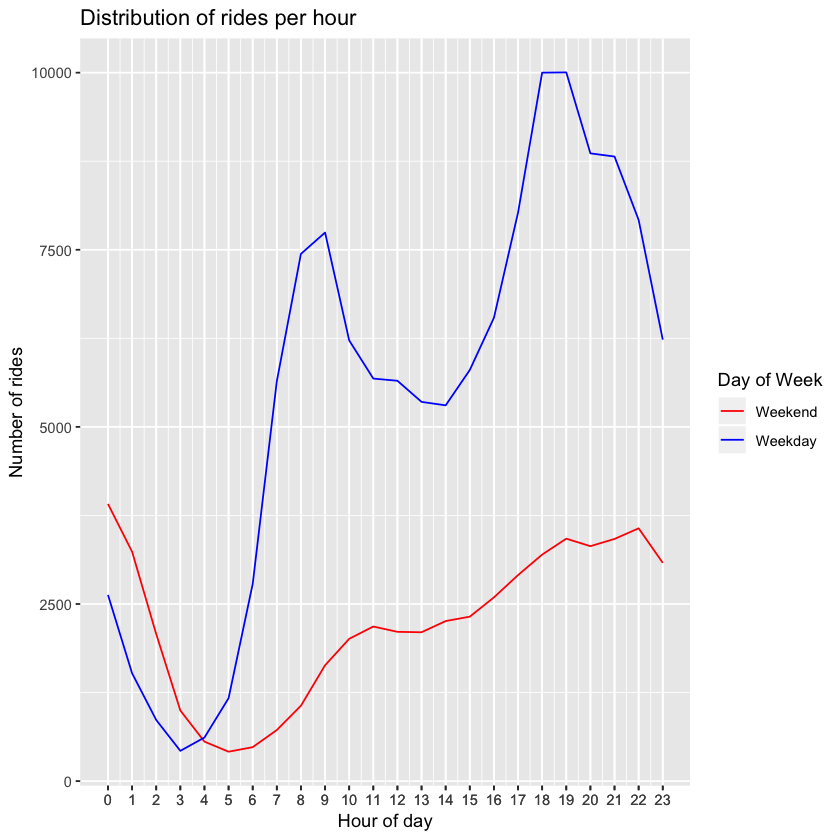

In [160]:
# Lets see how the hourly rides differ between weekdays and weekends
rides_driver_info <- rides_driver_info %>% mutate(weekdayFlag = ifelse(ride_weekDay %in% seq(2,6), 1, 0))
ridesRequestedPerHour_DOW <- rides_driver_info %>% group_by(ride_hour, weekdayFlag) %>% summarise(numOfRequestsHourly =  n_distinct(ride_id))

brks <-  ridesRequestedPerHour_DOW$ride_hour
ggplot(data=ridesRequestedPerHour_DOW, aes(x=ride_hour, y=numOfRequestsHourly, group=weekdayFlag, colour=factor(weekdayFlag))) + scale_x_time(labels = brks, breaks = brks) +
  geom_line() + scale_color_manual(name="Day of Week", labels=c("Weekend", "Weekday"), values = c("red", "blue")) + labs(title = 'Distribution of rides per hour', y = 'Number of rides', x = 'Hour of day')

As expected, we see more rides requested on Weekend early mornings than of weekday mornings. Let's see how PrimeTime varies for weekdays and weekends.

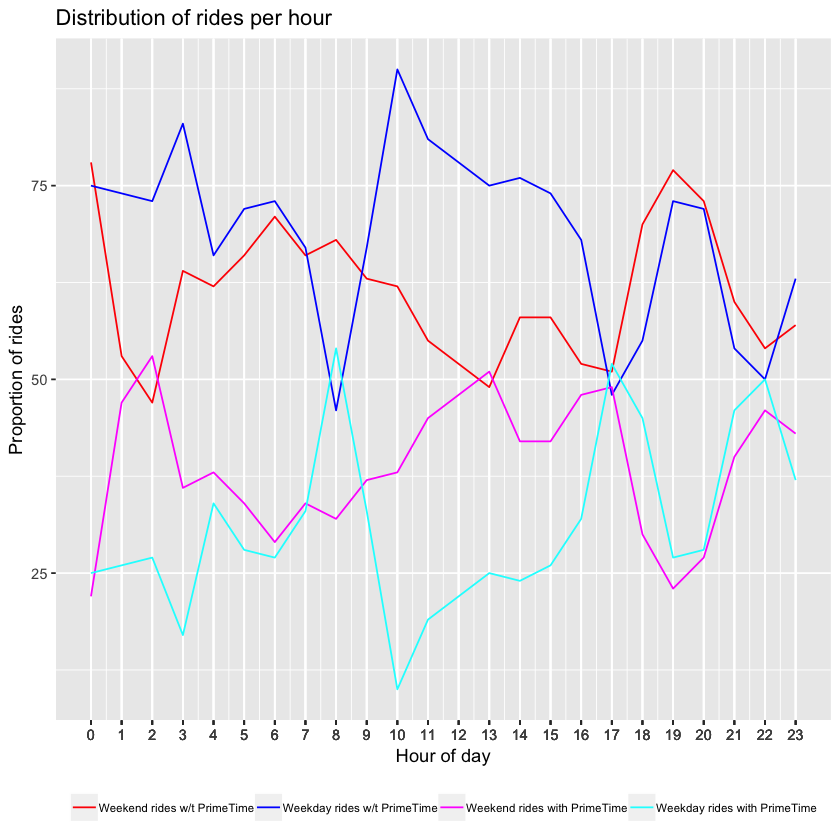

In [162]:
rides_driver_info <- rides_driver_info %>% mutate(primeTimeFlag = ifelse(ride_prime_time >0, 1, 0) , rushHourFlag = ifelse(ride_hour %in% c(seq(7,9), seq(17,19)) , 1, 0))
ridesRequestedPerHour_PrimeTime <- rides_driver_info %>% group_by(ride_hour, weekdayFlag, primeTimeFlag ) %>% summarise(numOfRequestsHourly =  n_distinct(ride_id))
ridesRequestedPerHour_PrimeTime <- merge(ridesRequestedPerHour_PrimeTime, ridesRequestedPerHour_DOW, by = c("ride_hour", "weekdayFlag"))
ridesRequestedPerHour_PrimeTime$percOfRequestsHourly <- with(ridesRequestedPerHour_PrimeTime, round((numOfRequestsHourly.x / numOfRequestsHourly.y)*100))

brks <-  ridesRequestedPerHour_PrimeTime$ride_hour
ggplot(data=ridesRequestedPerHour_PrimeTime, aes(x=ride_hour, y=percOfRequestsHourly, group=interaction(weekdayFlag, primeTimeFlag), colour=factor(interaction(weekdayFlag, primeTimeFlag)))) + scale_x_time(labels = brks, breaks = brks) +
    geom_line() + scale_color_manual(labels=c("Weekend rides w/t PrimeTime", "Weekday rides w/t PrimeTime", "Weekend rides with PrimeTime", "Weekday rides with PrimeTime"), 
    values = c("red","blue", "magenta", "cyan")) + theme(legend.title = element_blank(),legend.position = "bottom", legend.text = element_text(size = 7)) + labs(title = 'Distribution of rides per hour', y = 'Proportion of rides', x = 'Hour of day')

For weekends, we see that PrimeTime rides increases from early morning to mid-mornings. For the weekdays we can see that the PrimeTime rides increase during the rush hour.

In [164]:
table(rides_driver_info$ride_prime_time) # PrimeTime rates between 25 and 50 occur significantly higher than others


     0     25     50     75    100    150    200    250    300    350    400 
119477  32293  17033   7843   6007   1607    410     95     29     13     11 
   500 
     1 

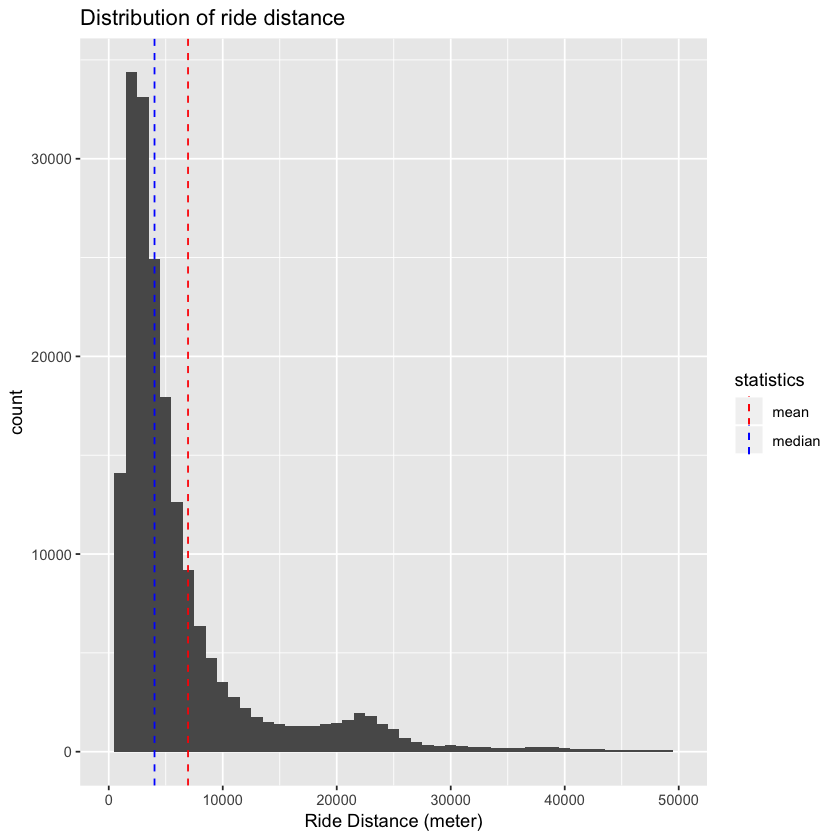

In [165]:
# Let's plot the histogram of ride duration and distance
ggplot (rideIds, aes(x = ride_distance)) + geom_histogram(binwidth = 1000) +  xlim(min(rideIds$ride_distance), 50000) + 
        labs(title="Distribution of ride distance", x="Ride Distance (meter)", y="count") + 
        geom_vline(aes(xintercept=mean(rideIds$ride_distance),  color="mean"), linetype="dashed") + 
        geom_vline(aes(xintercept=median(rideIds$ride_distance),color="median"), linetype="dashed") +
        scale_color_manual(name = "statistics", values = c(median = "blue", mean = "red"))

From the above histogram we can see a high percentage of rides have distance less than 10,000 meters with the average distance being ~7000 metres.

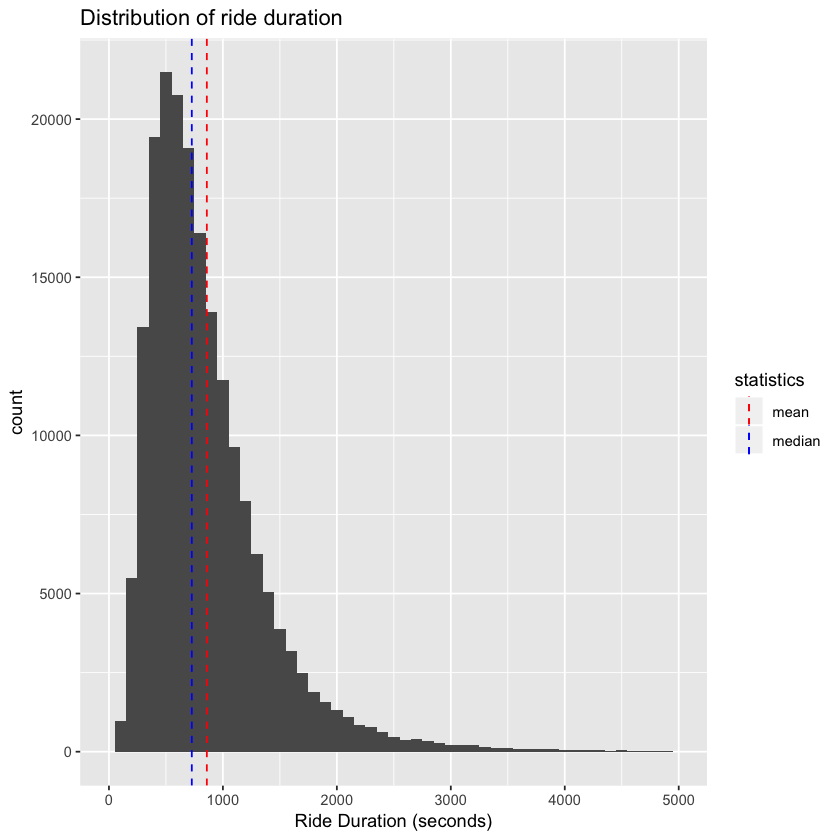

In [166]:
ggplot (rideIds, aes(x = ride_duration)) + geom_histogram(binwidth = 100) +  xlim(min(rideIds$ride_distance), 5000) + 
        labs(title="Distribution of ride duration", x="Ride Duration (seconds)", y="count") + 
        geom_vline(aes(xintercept=mean(rideIds$ride_duration),  color="mean"), linetype="dashed") + 
        geom_vline(aes(xintercept=median(rideIds$ride_duration),color="median"), linetype="dashed") +
        scale_color_manual(name = "statistics", values = c(median = "blue", mean = "red"))


From the above histogram we can see a high percentage of rides take less than 2000 seconds with the average duration being ~15 minutes. We now define an acceptable lower limit for ride_distance to be 1000m and ride_duration to be 120s. We will not cap the upper limit because its possible for drivers to book long distance rides (Example: Intercity rides).

In [167]:
rides_driver_info <- subset(rides_driver_info, ride_duration > 120 & ride_distance > 1000)  

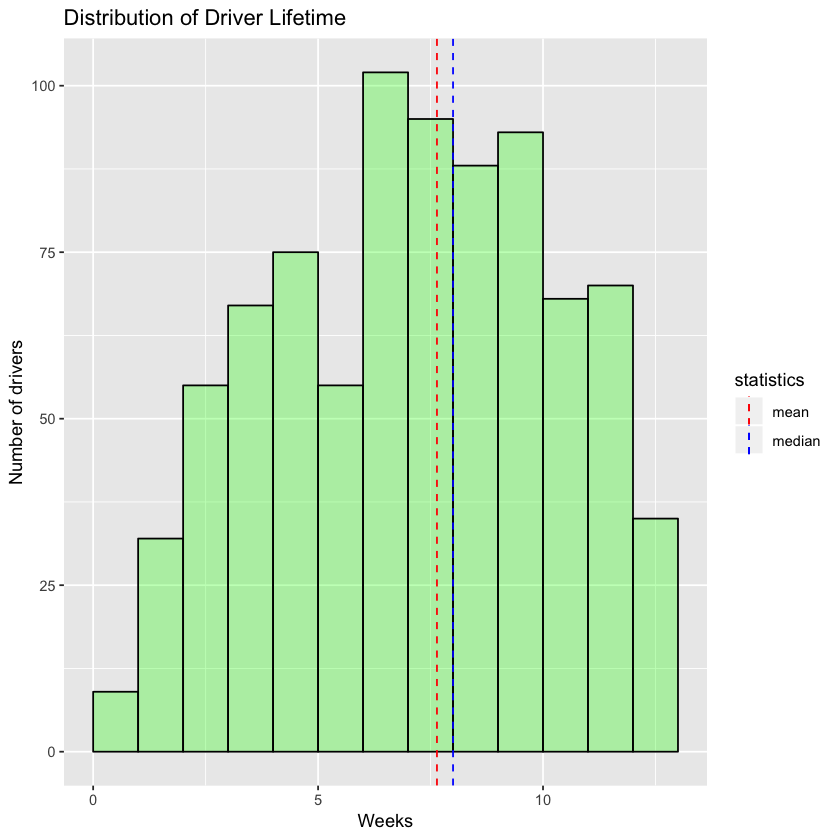

In [168]:
# Lets look at the lifetime of drivers
driverLifetimeDF <- rides_driver_info %>% group_by(driver_id) %>% summarise(countOfWeeks = n_distinct(ride_weekNum))
ggplot (driverLifetimeDF, aes (x = countOfWeeks)) + geom_histogram(breaks = seq(0, max(driverLifetimeDF$countOfWeeks), 1), col="black", 
        fill="green", alpha = .3) + labs(title="Distribution of Driver Lifetime") + labs(x="Weeks", y="Number of drivers") + 
        geom_vline(aes(xintercept=mean(driverLifetimeDF$countOfWeeks),  color="mean"), linetype="dashed") + 
        geom_vline(aes(xintercept=median(driverLifetimeDF$countOfWeeks),color="median"), linetype="dashed") +
      scale_color_manual(name = "statistics", values = c(median = "blue", mean = "red"))

We see that an average driver works close to 8 weeks (this will be important when we design our experiment)

## Defining driver churn

For the purposes of this exercise we will assume if a driver doesn't drive 3 weeks from the last week (that is week starting  2016-06-20) he will be labeled as churned. Although, the obvious disadvantage of this method is that for "New" drivers (who onboard towards the end) not enough time would have passed for them to have churned. The decision to use 3 weeks say instead of 1 week is to make a much stringent distinction from those who may casually use Company-X on and off but do not churn. 

Another way for us to define if a driver has churned is to see if the gap between the 125th ride (driver bonus on completion of 125 rides) and 126th ride is more than 4 weeks then we say he will more likely churn in the long run (this is just a hypothesis but for this experiment we will go with the former definition).

I will use Logistic Regression to try and predict churn. 

The target will be the churn variable defined above

The feature set will include -

1. weekend_driver                : A binary flag which indicates if he drives on the weekend (total rides must be > 10)

2. weekdayPrimeTimeDriver        : A binary flag which indicated if the person drives during the peak hours of weekdays (M-F) (total rides must be > 10)

3. daysToComp50Rides             : How long (in days) did the driver take to complete his first 50 rides.

4. avg_ridesPerWeek              : Average number of rides per week

5. average_ride_distance_XX_days : Average distance driven by the driver in his first XX days [NOTE: XX=07 or XX=30]

6. average_ride_duration_XX_days : Average duration of rides in the first XX days [NOTE: XX=07 or XX=30]

7. no_rides_7_days               : No of rides in drivers first week (since the day he was activated)

From there we will split our dataset randomly into train/test sets in a 70/30 ratio and normalize features that are in the higher range than the others.

In [169]:
driversAll <- rides_driver_info %>% distinct(driver_id)
driversNotChurned <- rides_driver_info %>% select(driver_id, ride_weekNum) %>% group_by(driver_id) %>% filter(ride_weekNum %in% c(23, 24, 25, 26)) %>% 
                      mutate(churnFlag = 0) %>% distinct(driver_id, churnFlag)
driversAllFinal <- merge(driversAll, driversNotChurned, all.x = TRUE, by = c('driver_id'))
driversAllFinal$churnFlag[is.na(driversAllFinal$churnFlag)] <- 1
driversAllFinal$churnFlag <- factor(driversAllFinal$churnFlag)

# Create additional features 
driverRidesPerWeek1 <- rides_driver_info %>% group_by(driver_id, ride_weekNum) %>% summarise(count = n_distinct(ride_id))
driverRidesPerWeek <- driverRidesPerWeek1 %>% group_by(driver_id) %>% summarise(avg_ridesPerWeek = mean(count, trim = 0.05, na.rm = TRUE))

daysToComp50Rides <- rides_driver_info %>% group_by(driver_id) %>% arrange(ride_DOY, ride_hour) %>% mutate(rowNumber = row_number()) %>%
                     filter(rowNumber <= 50) %>% summarise(max_ride_DOY = max(ride_DOY), min_ride_DOY = min(ride_DOY))
daysToComp50Rides$days_to_complete_50rides <- with(daysToComp50Rides, max_ride_DOY - min_ride_DOY)
daysToComp50Rides <- subset(daysToComp50Rides, select = c("driver_id", "days_to_complete_50rides"))

weekdayPrimeTimeDriver <- rides_driver_info %>% group_by(driver_id) %>% filter(weekdayFlag==1, primeTimeFlag==1) %>% 
                         summarise(numOfRides = n_distinct(ride_id), weekday_primeTime_flag = ifelse(numOfRides > 10, 1, 0)) %>% 
                        select(driver_id, weekday_primeTime_flag)
weekendDriver <- rides_driver_info %>% group_by(driver_id) %>% filter(weekdayFlag==0) %>% summarise(numOfRides = n_distinct(ride_id), 
                 weekend_flag = ifelse(numOfRides > 10, 1, 0)) %>% select(driver_id, weekend_flag)
features30Days <- rides_driver_info %>% group_by(driver_id) %>% arrange(ride_date) %>% filter(ride_date < as.Date(first(ride_date)+30)) %>%
                  summarise(average_ride_duration_30_days = mean(ride_duration), average_ride_distance_30_days = mean(ride_distance))
features7Days <- rides_driver_info %>% group_by(driver_id) %>% arrange(ride_date) %>% filter(ride_date < as.Date(first(ride_date)+7)) %>%
                 summarise(average_ride_duration_7_days = mean(ride_duration), average_ride_distance_7_days = mean(ride_distance), 
                 num_rides_7_days = n_distinct(ride_id))

driverFeatureDF <- Reduce(function(x, y) merge(x, y, by=c('driver_id'), all=TRUE), list(driverRidesPerWeek, daysToComp50Rides, 
                                    weekdayPrimeTimeDriver, weekendDriver, features30Days, features7Days, driversAllFinal ))
driverFeatureDF[is.na(driverFeatureDF)] <- 0

In [170]:
# Split randomly 70/30
sampleSize <- floor(0.70*nrow(driverFeatureDF))
trainIndex <- sample(seq_len(nrow(driverFeatureDF)),size = sampleSize)
trainDF <- driverFeatureDF[trainIndex,] #creates the training dataset with row numbers stored in train_ind
testDF <- driverFeatureDF[-trainIndex,]  

# Scale our features
maxAvgDist30Days <- max(trainDF$average_ride_distance_30_days)
maxAvgDist7Days <- max(trainDF$average_ride_distance_7_days)
maxAvgDuration30Days <- max(trainDF$average_ride_duration_30_days)
maxAvgDuration7Days <- max(trainDF$average_ride_duration_7_days)

normalize <- function(x, min_x=0, max_x) {
  return ((x - min_x) / (max_x - min_x))
}

# For the trainDF 
trainDF$norm_average_ride_duration_30_days <- normalize(trainDF$average_ride_duration_30_days, min_x = 0, max_x = maxAvgDuration30Days)
trainDF$norm_average_ride_duration_7_days <- normalize(trainDF$average_ride_duration_7_days, min_x = 0, max_x = maxAvgDuration7Days)
trainDF$norm_average_ride_distance_30_days <- normalize(trainDF$average_ride_distance_30_days, min_x = 0, max_x = maxAvgDist30Days)
trainDF$norm_average_ride_distance_7_days <- normalize(trainDF$average_ride_distance_7_days, min_x = 0, max_x = maxAvgDist7Days)

# Now do the testDF 
testDF$norm_average_ride_duration_30_days <- normalize(testDF$average_ride_duration_30_days, min_x = 0, max_x = maxAvgDuration30Days)
testDF$norm_average_ride_duration_7_days <- normalize(testDF$average_ride_duration_7_days, min_x = 0, max_x = maxAvgDuration7Days)
testDF$norm_average_ride_distance_30_days <- normalize(testDF$average_ride_distance_30_days, min_x = 0, max_x = maxAvgDist30Days)
testDF$norm_average_ride_distance_7_days <- normalize(testDF$average_ride_distance_7_days, min_x = 0, max_x = maxAvgDist7Days)


In [171]:
logRegModel <- glm(churnFlag ~ avg_ridesPerWeek + days_to_complete_50rides + weekday_primeTime_flag + weekend_flag + norm_average_ride_duration_30_days
              + norm_average_ride_duration_7_days + norm_average_ride_distance_30_days + norm_average_ride_distance_30_days + num_rides_7_days, trainDF, family = "binomial")
varImp(logRegModel)

,Overall
avg_ridesPerWeek,3.94798667
days_to_complete_50rides,7.76040697
weekday_primeTime_flag,7.15393180
weekend_flag,4.41413899
norm_average_ride_duration_30_days,1.23245523
norm_average_ride_duration_7_days,0.00968187
norm_average_ride_distance_30_days,2.22784386
num_rides_7_days,0.59191516


We see that days_to_complete_50rides, weekday_primeTime_flag, avg_ridesPerWeek and weekend_flag come out on top to be the four most significant predictors. With an imbalance in our classes, lets see how our model fares through a confusion matrix.

In [172]:
predicted <- predict(logRegModel, newdata = subset(testDF,select=c('avg_ridesPerWeek', 'days_to_complete_50rides', 'weekday_primeTime_flag', 'weekend_flag', 'norm_average_ride_duration_30_days',
              'norm_average_ride_duration_7_days', 'norm_average_ride_distance_30_days', 'norm_average_ride_distance_30_days', 'num_rides_7_days')),type='response')
predicted <- ifelse(predicted > 0.5,1,0)
table(as.factor(testDF$churnFlag),as.factor(predicted)) # total cases n=254

   
      0   1
  0 177   8
  1  28  41

From the table above, we see that we had 49 cases of churn of which we accurately predicted 41 which is a ~83.67% accuracy. From the not-churned case, we see 13.65% were inaccurately labeled as churned. This gives us a pretty good idea about the next steps: we could invest some time to come with more discriminative features (maybe even interaction of some of these features), we can also leverage a non-parametric model (Example: Random Forest which is known to have good accuracy but we lose the ability to make interpretations from these models to understand the contribution of different features. Unlike a parametric model like logistic regression where we have the ability to interpret the model and make more informed business decisions from it RF are essentially a black box), we could build an ensemble which can be robust where each individual model is built on different assumptions.

## Sizing the opportunities

The cost of acquiring new customers (in this case drivers) is expensive for most businesses. The costs associated with acquiring new drivers is without a doubt a high expense for Company-X: giving new drivers incentives such as the sign-up bonuses as high as $2000 to complete a certain number of rides, the time and money spent in onboarding new drivers along with the other sales and marketing costs to attract new riders.

Hence, retaining drivers should be a priority. Some ways we can reduce churn is to show a projections of earnings ,using existing data, for 7 days, 6 months and 1 year out, start the retention process in the early phases when they are still open to driving, offer some other support as well such as discounts on regular car maintainence.

Let's discuss the following two hypotheses, to reduce churn, in detail:
1. Doubling the number of rides in an activated driver’s first week 
     How do we get drivers to complete more rides in their first week ? Maybe through an incentive. It could be to complete a fixed number of rides by the first week they start driving. While this may increase the number of rides there will be that aditional cost of giving bonuses. This may work for drivers for whom driving for Company-X is their primary job but this may not work for drivers who have atleast one other full-time job as they do not have enough time to double their rides. Let's look at our data to see if this change could be a significant driver to decrease churn.

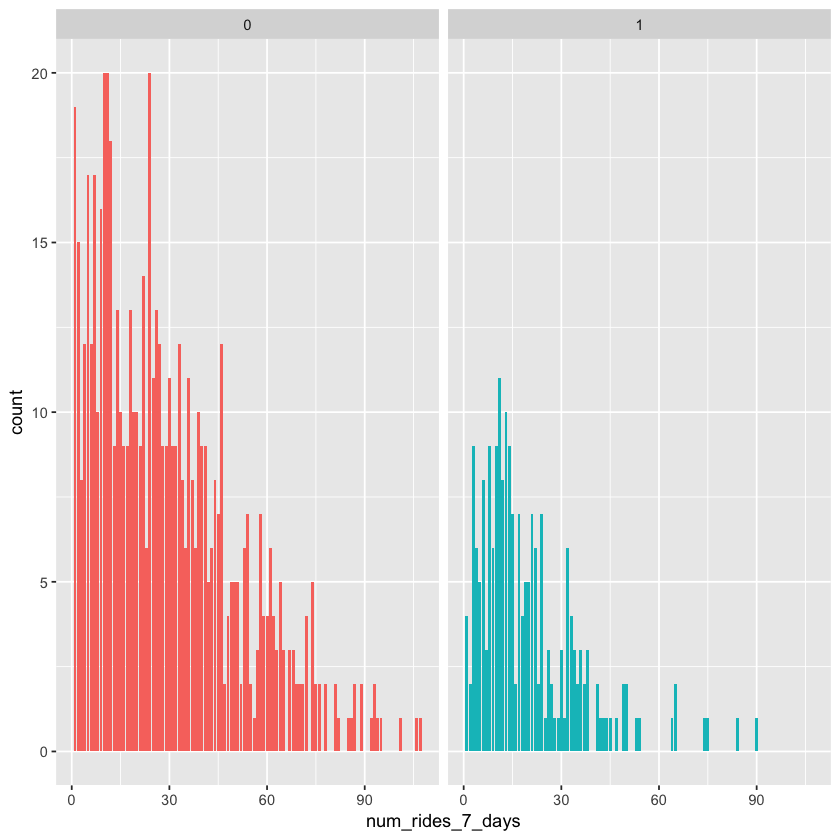

In [173]:
ggplot(driverFeatureDF, aes(num_rides_7_days, fill = churnFlag)) + geom_bar() +
  theme(legend.position = "none") + facet_grid(~churnFlag)

From the plot above, we see that there are significantly more not-churned drivers who complete <40 rides in their first week. We see almost a similar behavior for the churned drivers. Our conclusion is that while this would have a nice by product of increasing rides (through only a segment of drivers) but may have poor returns in terms of revenue, it would not succeed in reducing in decreasing driver churn.

2. Increasing their PrimeTime Rides
       There could be incentives provided here too (complete X number of rides during peak hours and get a bonus). While there is that additional cost of giving bonuses as discussed above, the revenue generated here would be higher (to both drivers and Company-X) and will have a higher return on giving incentives. This could help prioritize both segments of drivers, to balance their driving hours more toward the peak hours and that being the busiet time in that the demand is high, there is consistent need for additional drivers on the road. Let's look take a look at the plot below

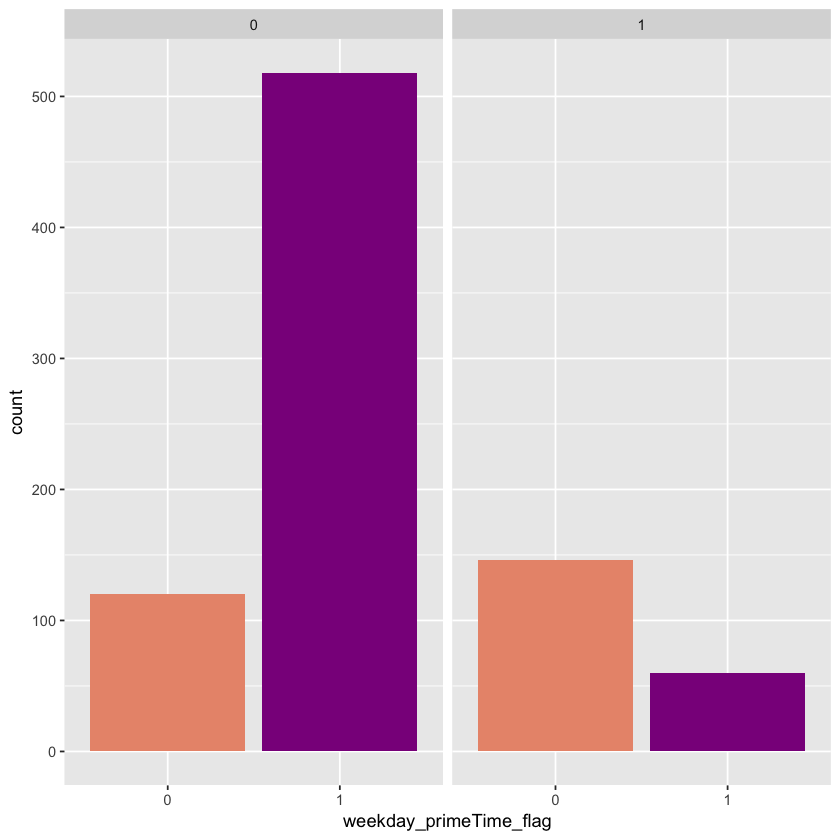

In [174]:
driverFeatureDF$weekday_primeTime_flag <- factor(driverFeatureDF$weekday_primeTime_flag)
ggplot(driverFeatureDF, aes(weekday_primeTime_flag, fill = weekday_primeTime_flag)) + geom_bar() +
  theme(legend.position = "none") + facet_grid(~churnFlag) + scale_fill_manual(values = c( "darksalmon", "darkmagenta"))

Higher percentage of not-churned drivers are infact those that utilize the peak Time. Our conclusion is that this would have a significant impact on driver retention.